In [2]:
from huggingface_hub import login
from transformers import AutoTokenizer, AutoModelForCausalLM, LlamaForCausalLM
from transformers import LlamaForCausalLM
import torch.nn as nn
import torch

login(token = "hf_")

2025-04-29 15:09:34.823637: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745939375.067128      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745939375.136625      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Imported trained model with extra embedding in architecture

In [4]:
from transformers import LlamaForCausalLM
import torch.nn as nn

class LlamaWithExtraEmbeddings(LlamaForCausalLM):
    def __init__(self, config):
        super().__init__(config)
        
        original_vocab_size, embedding_dim = self.model.embed_tokens.weight.shape
        self.model.extra_embedding_1 = nn.Embedding(original_vocab_size, embedding_dim)
        self.model.extra_embedding_2 = nn.Embedding(original_vocab_size, embedding_dim)

In [5]:
model = LlamaWithExtraEmbeddings.from_pretrained("/kaggle/input/updated-model/pytorch/default/1/saved_model")

In [6]:
model

LlamaWithExtraEmbeddings(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 768)
    (layers): ModuleList(
      (0-11): 12 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=768, out_features=768, bias=False)
          (k_proj): Linear(in_features=768, out_features=768, bias=False)
          (v_proj): Linear(in_features=768, out_features=768, bias=False)
          (o_proj): Linear(in_features=768, out_features=768, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=768, out_features=2048, bias=False)
          (up_proj): Linear(in_features=768, out_features=2048, bias=False)
          (down_proj): Linear(in_features=2048, out_features=768, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((768,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((768,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((768,), eps=1e-05)
    (rotary_emb): Llama

In [8]:
def tokenize(examples, tokenizer):
    texts = [f"### Instruction: {instruction}\n### Response: {output}" 
             for instruction, output in zip(examples['instruction'], examples['output'])]
    
    tokenized = tokenizer(
        texts,
        truncation=True,
        max_length=1024,
        padding="max_length",
        return_tensors=None
    )
        
    # Add labels for causal language modeling
    tokenized["labels"] = [ids.copy() for ids in tokenized["input_ids"]]
    return tokenized

## Processing of dataset

In [7]:
import datasets
import gc
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, PreTrainedTokenizerFast, AutoModelForCausalLM

class MultiTokenizerProcessor:
    def __init__(self, tokenizers, max_length=1024, separator_token=200000):
        """
        Initialize the MultiTokenizerProcessor with a list of tokenizers.
        
        Args:
        - tokenizers: A list of tokenizers to use for tokenization.
        - max_length: The maximum length for tokenized sequences (default 1024).
        - separator_token: The token to be used as a separator between tokenized text.
        """
        self.tokenizers = tokenizers
        self.max_length = max_length
        self.separator_token = separator_token

    def tokenize_and_unify(self, ds, remove_columns=['instruction', "source", "score", 'output']):
        """
        Tokenizes the dataset with different tokenizers and unifies them into a single dataset.
        
        Args:
        - ds: The dataset to be tokenized.
        - tokenizers: A list of tokenizers to use for tokenization.
        - remove_columns: Columns to be removed from the dataset before tokenization (default includes 'instruction', 'source', etc.)
        
        Returns:
        - unified_tokenized_text: A dataset containing tokenized text from all tokenizers.
        """
        
        tokenized_texts = []
        
        for idx, tokenizer in enumerate(self.tokenizers):
            # Set pad token to eos_token
            tokenizer.pad_token = tokenizer.eos_token
            
            # Tokenize the dataset
            tokenized_text = ds.map(lambda examples: self.tokenize(examples, tokenizer), batched=True, remove_columns=remove_columns)
            
            # Rename columns for each tokenizer's result
            tokenized_text = tokenized_text.rename_column("input_ids", f"input_ids{idx+1}")
            tokenized_text = tokenized_text.rename_column("attention_mask", f"attention_mask{idx+1}")
            tokenized_text = tokenized_text.rename_column("labels", f"labels{idx+1}")
    
            if tokenizer != self.tokenizers[0]:
                # Remove token_type_ids column
                tokenized_text = tokenized_text.remove_columns(['token_type_ids'])
            
            # Append tokenized dataset to list
            tokenized_texts.append(tokenized_text)
        
        # Concatenate all tokenized datasets horizontally
        unified_tokenized_text = datasets.concatenate_datasets(tokenized_texts, axis=1)
        
        # Free memory
        del tokenized_texts
        gc.collect()
    
        return unified_tokenized_text

    def tokenize(self, examples, tokenizer):
        texts = [f"### Instruction: {instruction}\n### Response: {output}" 
                 for instruction, output in zip(examples['instruction'], examples['output'])]
        
        tokenized = tokenizer(
            texts,
            truncation=True,
            max_length=1024,
            padding="max_length",
            return_tensors=None
        )
            
        # Add labels for causal language modeling
        tokenized["labels"] = [ids.copy() for ids in tokenized["input_ids"]]
        return tokenized
    
    def concat_rows(self, row):
        """
        Concatenates tokenized rows from multiple tokenizers with separator tokens.
        
        Args:
        - row: The row from the tokenized dataset.
        
        Returns:
        - A dictionary with concatenated input_ids, attention_mask, and labels.
        """
        sep = [self.separator_token]
        
        combined_input_ids = row['input_ids1'] + sep + row['input_ids2'] + sep + row['input_ids3']
        combined_attention_mask = row['attention_mask1'] + sep + row['attention_mask2'] + sep + row['attention_mask3']
        combined_labels = row['labels1']  # Assuming labels from the first tokenizer
        
        return {
            'input_ids': combined_input_ids,
            'attention_mask': combined_attention_mask,
            'labels': combined_labels
        }

    def data_collator(self, features):
        """
        Custom data collator for handling input from multiple tokenizers with separator tokens.
        
        Args:
        - features: The batch of features.
        
        Returns:
        - A dictionary with the collated input_ids, attention_mask, and labels.
        """
        input_ids = torch.stack([torch.tensor(f["input_ids"]) for f in features])
        attention_mask = torch.stack([torch.tensor(f["attention_mask"]) for f in features])
        labels = torch.stack([torch.tensor(f["labels"]) for f in features])
        
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels
        }
    
    def create_data_loader(self, ds, batch_size=1):
        """
        Creates a DataLoader for the tokenized dataset.
        
        Args:
        - ds: The tokenized dataset.
        - batch_size: The batch size for the DataLoader (default 1).
        
        Returns:
        - A DataLoader for the tokenized dataset.
        """
        return DataLoader(
            ds,
            batch_size=batch_size,
            collate_fn=self.data_collator
        )

In [8]:
original_tokenizer = AutoTokenizer.from_pretrained("nickypro/tinyllama-110M", legacy=False)
wordpiece_tokenizer = AutoTokenizer.from_pretrained("/kaggle/input/nlp-tokenizers/tokenizers/wordpiece_tokenizer")
unigram_tokenizer = AutoTokenizer.from_pretrained("/kaggle/input/nlp-tokenizers/tokenizers/unigram_tokenizer")

# Instantiate the processor with the tokenizers
processor = MultiTokenizerProcessor(
    tokenizers=[original_tokenizer, wordpiece_tokenizer, unigram_tokenizer]
)

In [9]:
from datasets import load_dataset

ds = load_dataset("mlabonne/FineTome-Alpaca-100k", split="train")

# Tokenize and unify
unified_tokenized_text = processor.tokenize_and_unify(ds)

# Concatenate rows with separator tokens
unified_tokenized_text = unified_tokenized_text.map(
    lambda row: processor.concat_rows(row),
    remove_columns=['input_ids1', 'input_ids2', 'input_ids3', 'attention_mask1', 'attention_mask2', 'attention_mask3', 'labels1', 'labels2', 'labels3']
)

# Create the DataLoader
loader = processor.create_data_loader(unified_tokenized_text)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Iterate over the DataLoader
batch = next(iter(loader))
batch = {k: v.to(device) for k, v in batch.items()}

README.md:   0%|          | 0.00/408 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/89.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

In [14]:

import types
from transformers import AutoTokenizer
import torch

def combine_tokenizations(text, max_length=768, sep_token_id=200000):
    # Load tokenizers
    original_tokenizer = AutoTokenizer.from_pretrained("nickypro/tinyllama-110M")
    wordpiece_tokenizer = AutoTokenizer.from_pretrained("/kaggle/input/nlp-tokenizers/tokenizers/wordpiece_tokenizer")
    unigram_tokenizer = AutoTokenizer.from_pretrained("/kaggle/input/nlp-tokenizers/tokenizers/unigram_tokenizer")

    # Ensure right padding and pad token ids
    for tokenizer in [original_tokenizer, wordpiece_tokenizer, unigram_tokenizer]:
        tokenizer.padding_side = "right"
        tokenizer.pad_token_id = tokenizer.eos_token_id

    # Tokenize
    original_tokens = original_tokenizer(text, padding='max_length', max_length=max_length, truncation=True)
    wordpiece_tokens = wordpiece_tokenizer(text, padding='max_length', max_length=max_length, truncation=True)
    unigram_tokens = unigram_tokenizer(text, padding='max_length', max_length=max_length, truncation=True)

    # Combine with separator
    combined_input_ids = (
        original_tokens["input_ids"] + [sep_token_id] +
        wordpiece_tokens["input_ids"] + [sep_token_id] +
        unigram_tokens["input_ids"]
    )
    combined_attention_mask = (
        original_tokens["attention_mask"] + [sep_token_id] +
        wordpiece_tokens["attention_mask"] + [sep_token_id] +
        unigram_tokens["attention_mask"]
    )

    return {
        "input_ids": torch.tensor([combined_input_ids], device=model.device).long(),
        "attention_mask": torch.tensor([combined_attention_mask], device=model.device).long()
    }


# Combined Tokenization methods

## Inference on trained tiny llama with summarization technique

In [12]:
from huggingface_hub import login
from transformers import AutoTokenizer, AutoModelForCausalLM, LlamaForCausalLM
from transformers import LlamaForCausalLM
import torch.nn as nn
import torch

model = LlamaWithExtraEmbeddings.from_pretrained("/kaggle/input/updated-model/pytorch/default/1/saved_model")

from typing import List, Optional, Union
from cachetools import Cache
import types

def modified_forward(
    self,
    input_ids: torch.LongTensor = None,
    attention_mask: Optional[torch.Tensor] = None,
    position_ids: Optional[torch.LongTensor] = None,
    past_key_values: Optional[Union[Cache, List[torch.FloatTensor]]] = None,
    inputs_embeds: Optional[torch.FloatTensor] = None,
    labels: Optional[torch.LongTensor] = None,
    use_cache: Optional[bool] = None,
    output_attentions: Optional[bool] = None,
    output_hidden_states: Optional[bool] = None,
    return_dict: Optional[bool] = None,
    cache_position: Optional[torch.LongTensor] = None,
    num_logits_to_keep: int = 0,
    **kwargs
):
    if input_ids is None and inputs_embeds is None:
        raise ValueError("You have to specify either input_ids or inputs_embeds")

    batch_size = input_ids.shape[0]
    combined_embeds = []
    print(batch_size)
    try:
        for batch_idx in range(batch_size):
            str_input_ids = " ".join([str(i) for i in input_ids[batch_idx].tolist()])
            input_ids_parts = str_input_ids.split(" 200000 ")
            print(len(input_ids_parts), input_ids_parts)
            bpe = list(map(int, input_ids_parts[0].split(" ")))
            wordpiece = list(map(int, input_ids_parts[1].split(" ")))
            unigram = list(map(int, input_ids_parts[2].split(" ")))
            
            bpe += [original_tokenizer.pad_token_id] * (len(input_ids[batch_idx].tolist()) - len(bpe))
            wordpiece += [wordpiece_tokenizer.pad_token_id] * (len(input_ids[batch_idx].tolist()) - len(wordpiece))
            unigram += [unigram_tokenizer.pad_token_id] * (len(input_ids[batch_idx].tolist()) - len(unigram))

            bpe = torch.tensor(bpe, device=model.device).unsqueeze(0).long()
            wordpiece = torch.tensor(wordpiece, device=model.device).unsqueeze(0).long()
            unigram = torch.tensor(unigram, device=model.device).unsqueeze(0).long()
            
            bpe_embedding = self.model.embed_tokens(bpe)
            wordpiece_embedding = self.model.extra_embedding_1(wordpiece)
            unigram_embedding = self.model.extra_embedding_2(unigram)
            
            # print(f"Shapes: BPE {bpe_embedding.shape}, Unigram {unigram_embedding.shape}, SentencePiece {sentencepiece_embedding.shape}")
            
            min_length = min(bpe_embedding.shape[1], wordpiece_embedding.shape[1], unigram_embedding.shape[1])
            bpe_embedding = bpe_embedding[:, :min_length, :]
            wordpiece_embedding = wordpiece_embedding[:, :min_length, :]
            unigram_embedding = unigram_embedding[:, :min_length, :]
            
            batch_embeds = bpe_embedding + wordpiece_embedding + unigram_embedding
            combined_embeds.append(batch_embeds)

        inputs_embeds = torch.cat(combined_embeds, dim=0)
        # print(f"Final inputs_embeds shape: {inputs_embeds.shape}")
        
        if attention_mask is not None:
            attention_mask = attention_mask[batch_idx].tolist()
            attention_mask = attention_mask[:len(input_ids_parts[0].split(" "))]
            print(attention_mask)
            attention_mask += [0] * (len(input_ids[batch_idx].tolist()) - len(bpe))
            print(attention_mask)
            attention_mask = torch.tensor(attention_mask, device=model.device).unsqueeze(0).long()
        
        input_ids = None

    except IndexError as e:
        # print(input_ids, inputs_embeds)
        pass
        

    return self.original_forward(
        input_ids=input_ids,
        attention_mask=attention_mask,
        position_ids=position_ids,
        past_key_values=past_key_values,
        inputs_embeds=inputs_embeds,
        use_cache=use_cache,
        output_attentions=output_attentions,
        output_hidden_states=output_hidden_states,
        return_dict=return_dict,
        cache_position=cache_position,
        labels=labels,
        num_logits_to_keep=num_logits_to_keep,
        **kwargs
    )
    
model.original_forward = model.forward
model.forward = types.MethodType(modified_forward, model)

result = combine_tokenizations("Can you tell me a joke?", max_length=10)
    
output = model.generate(
    input_ids=result["input_ids"],
    attention_mask=result["attention_mask"],
)

print("Generated text:")
for i in range(output.shape[0]):
    generated_text = original_tokenizer.decode(output[i], skip_special_tokens=True)
    print(generated_text)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


1
3 ['1 1815 366 2649 592 263 2958 446 29973 2', '1 118 71 479 87 24 6305 22 2 2', '1 313 293 774 276 267 263 3252 336 2']
[1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1
1 ['2649']
1
1 ['263']
1
1 ['2958']
1
1 ['446']
1
1 ['3026']
1
1 ['3026']
1
1 ['3026']
1
1 ['3026']
1
1 ['3026']
1
1 ['670']
1
1 ['3026']
1
1 ['3600']
1
1 ['16823']
1
1 ['3026']
1
1 ['3600']
1
1 ['16823']
1
1 ['471']
1
1 ['3026']
1
1 ['3600']
Generated text:
Can you tell me a joke?sDgeT которы (icebrees a twra tell a joke?"?"?"?"?" his?" His mom?" His mom was?" His mom


## 1. Method: Average of Embeddings

In [17]:
model = LlamaWithExtraEmbeddings.from_pretrained("/kaggle/input/updated-model/pytorch/default/1/saved_model")

In [18]:
from typing import List, Optional, Union
from cachetools import Cache
import types
import torch

def modified_forward(
    self,
    input_ids: torch.LongTensor = None,
    attention_mask: Optional[torch.Tensor] = None,
    position_ids: Optional[torch.LongTensor] = None,
    past_key_values: Optional[Union[Cache, List[torch.FloatTensor]]] = None,
    inputs_embeds: Optional[torch.FloatTensor] = None,
    labels: Optional[torch.LongTensor] = None,
    use_cache: Optional[bool] = None,
    output_attentions: Optional[bool] = None,
    output_hidden_states: Optional[bool] = None,
    return_dict: Optional[bool] = None,
    cache_position: Optional[torch.LongTensor] = None,
    num_logits_to_keep: int = 0,
    **kwargs
):
    if input_ids is None and inputs_embeds is None:
        raise ValueError("You have to specify either input_ids or inputs_embeds")

    batch_size = input_ids.shape[0]
    combined_embeds = []

    for batch_idx in range(batch_size):
        str_input_ids = " ".join([str(i) for i in input_ids[batch_idx].tolist()])
        input_ids_parts = str_input_ids.split(" 200000 ")

        embed_list = []
        count = 0

        if self.embedding_config.get("use_bpe", False):
            bpe_ids = torch.tensor([list(map(int, input_ids_parts[0].split(" ")))], device=input_ids.device)
            bpe_emb = self.model.embed_tokens(bpe_ids)
            embed_list.append(bpe_emb)
            count += 1

        if self.embedding_config.get("use_wordpiece", False):
            wp_ids = torch.tensor([list(map(int, input_ids_parts[1].split(" ")))], device=input_ids.device)
            wp_emb = self.model.extra_embedding_1(wp_ids)
            embed_list.append(wp_emb)
            count += 1

        if self.embedding_config.get("use_unigram", False):
            uni_ids = torch.tensor([list(map(int, input_ids_parts[2].split(" ")))], device=input_ids.device)
            uni_emb = self.model.extra_embedding_2(uni_ids)
            embed_list.append(uni_emb)
            count += 1

        min_len = min(e.shape[1] for e in embed_list)
        embed_list = [e[:, :min_len, :] for e in embed_list]
        averaged = sum(embed_list) / count
        combined_embeds.append(averaged)

    inputs_embeds = torch.cat(combined_embeds, dim=0)

    if attention_mask is not None:
        attention_mask = attention_mask[:, :inputs_embeds.shape[1]]

    return self.original_forward(
        input_ids=None,
        attention_mask=attention_mask,
        position_ids=position_ids,
        past_key_values=past_key_values,
        inputs_embeds=inputs_embeds,
        use_cache=use_cache,
        output_attentions=output_attentions,
        output_hidden_states=output_hidden_states,
        return_dict=return_dict,
        cache_position=cache_position,
        labels=labels,
        num_logits_to_keep=num_logits_to_keep,
        **kwargs
    )

In [19]:
model.original_forward = model.forward
model.forward = types.MethodType(modified_forward, model)

In [20]:
model.embedding_config = {
    "use_bpe": True,         # original
    "use_wordpiece": True,   # wordpiece_tokenizer
    "use_unigram": True      # unigram_tokenizer
}


In [21]:
# Create a new name for the model
model_mean_emb = model.to(device)

# Now you can use `my_model` instead of `model`
model_mean_emb.eval()
with torch.no_grad():
    output = model_mean_emb(
        input_ids=batch["input_ids"],
        attention_mask=batch["attention_mask"],
        labels=batch["labels"]
    )

print("Loss:", output.loss.item())
print("Logits shape:", output.logits.shape)

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Loss: 8.780935287475586
Logits shape: torch.Size([1, 1024, 32000])


### Mean avg model inference

In [22]:

import types
from transformers import AutoTokenizer
import torch

def combine_tokenizations(text, max_length=10, sep_token_id=200000):
    # Load tokenizers
    original_tokenizer = AutoTokenizer.from_pretrained("nickypro/tinyllama-110M")
    wordpiece_tokenizer = AutoTokenizer.from_pretrained("/kaggle/input/nlp-tokenizers/tokenizers/wordpiece_tokenizer")
    unigram_tokenizer = AutoTokenizer.from_pretrained("/kaggle/input/nlp-tokenizers/tokenizers/unigram_tokenizer")

    # Ensure right padding and pad token ids
    for tokenizer in [original_tokenizer, wordpiece_tokenizer, unigram_tokenizer]:
        tokenizer.padding_side = "right"
        tokenizer.pad_token_id = tokenizer.eos_token_id

    # Tokenize
    original_tokens = original_tokenizer(text, padding='max_length', max_length=max_length, truncation=True)
    wordpiece_tokens = wordpiece_tokenizer(text, padding='max_length', max_length=max_length, truncation=True)
    unigram_tokens = unigram_tokenizer(text, padding='max_length', max_length=max_length, truncation=True)

    # Combine with separator
    combined_input_ids = (
        original_tokens["input_ids"] + [sep_token_id] +
        wordpiece_tokens["input_ids"] + [sep_token_id] +
        unigram_tokens["input_ids"]
    )
    combined_attention_mask = (
        original_tokens["attention_mask"] + [0] +
        wordpiece_tokens["attention_mask"] + [0] +
        unigram_tokens["attention_mask"]
    )

    return {
        "input_ids": torch.tensor([combined_input_ids], device=model.device).long(),
        "attention_mask": torch.tensor([combined_attention_mask], device=model.device).long()
    }


In [24]:
model_mean_emb.eval()

# Example input text (you can replace it with any instruction)
example_text = "### Instruction: Please tell what is the sun?\n### Response:"

original_tokenizer = AutoTokenizer.from_pretrained("nickypro/tinyllama-110M")
wordpiece_tokenizer = AutoTokenizer.from_pretrained("/kaggle/input/nlp-tokenizers/tokenizers/wordpiece_tokenizer")
unigram_tokenizer = AutoTokenizer.from_pretrained("/kaggle/input/nlp-tokenizers/tokenizers/unigram_tokenizer")

original_tokenizer.padding_side = "right"

original_tokenizer.pad_token = original_tokenizer.eos_token
wordpiece_tokenizer.pad_token = wordpiece_tokenizer.eos_token
unigram_tokenizer.pad_token = unigram_tokenizer.eos_token

# Tokenize separately using each tokenizer
original_encoded = original_tokenizer(example_text, return_tensors="pt", padding="max_length", max_length=20)
wordpiece_encoded = wordpiece_tokenizer(example_text, return_tensors="pt", padding="max_length", max_length=20)
unigram_encoded = unigram_tokenizer(example_text, return_tensors="pt", padding="max_length", max_length=20)

print("\nOriginal Tokenizer Encoded:")
print(original_encoded)

# print("\nWordPiece Tokenizer Encoded:")
# print(wordpiece_encoded)

# print("\nUnigram Tokenizer Encoded:")
# print(unigram_encoded)

# Concatenate the input_ids and attention_masks with separator 200000
sep_token = torch.tensor([[200000]], dtype=torch.long)

input_ids = torch.cat([
    original_encoded['input_ids'], sep_token,
    original_encoded['input_ids'], sep_token,
    original_encoded['input_ids']
], dim=1)

attention_mask = torch.cat([
    original_encoded['attention_mask'], sep_token,
    original_encoded['attention_mask'], sep_token,
    original_encoded['attention_mask']
], dim=1)

print("\nConcatenated Input IDs:")
print(input_ids)

print("\nConcatenated Attention Mask:")
print(attention_mask)

# Move to device (GPU if available)
input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)

# Forward pass to get logits
with torch.no_grad():
    outputs = model_mean_emb(input_ids=input_ids, attention_mask=attention_mask)

# Get the generated logits
logits = outputs.logits

# Greedy decoding (take most probable token at each step)
predicted_token_ids = logits.argmax(dim=-1)

# (Optional) Remove the padding and separators for clean decoding
# Since we know separators (200000) are artificial, skip them
filtered_token_ids = predicted_token_ids[predicted_token_ids != 200000]

# Decode to text using the original tokenizer (or whichever you prefer)
generated_text = original_tokenizer.decode(filtered_token_ids, skip_special_tokens=True)

print("\nPredicted Token IDs:")
print(predicted_token_ids)

print("\nGenerated Text:\n")
print(generated_text)


Original Tokenizer Encoded:
{'input_ids': tensor([[    1,   835,  2799,  4080, 29901,  3529,  2649,   825,   338,   278,
          6575, 29973,    13,  2277, 29937, 13291, 29901,     2,     2,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]])}

Concatenated Input IDs:
tensor([[     1,    835,   2799,   4080,  29901,   3529,   2649,    825,    338,
            278,   6575,  29973,     13,   2277,  29937,  13291,  29901,      2,
              2,      2, 200000,      1,    835,   2799,   4080,  29901,   3529,
           2649,    825,    338,    278,   6575,  29973,     13,   2277,  29937,
          13291,  29901,      2,      2,      2, 200000,      1,    835,   2799,
           4080,  29901,   3529,   2649,    825,    338,    278,   6575,  29973,
             13,   2277,  29937,  13291,  29901,      2,      2,      2]])

Concatenated Attention Mask:
tensor([[     1,      1,      1,      1,      1,      1,      1,      1,      1,
         

## 2. Method: Concatenation of embeddings

In [26]:
from transformers import LlamaForCausalLM
import torch.nn as nn

class LlamaWithExtraEmbeddings(LlamaForCausalLM):
    def __init__(self, config):
        super().__init__(config)
        self.embedding_config = {
            "use_bpe": True,         # original
            "use_wordpiece": True,   # wordpiece_tokenizer
            "use_unigram": True      # unigram_tokenizer
        }

        original_vocab_size, embedding_dim = self.model.embed_tokens.weight.shape
        self.model.extra_embedding_1 = nn.Embedding(original_vocab_size, embedding_dim)
        self.model.extra_embedding_2 = nn.Embedding(original_vocab_size, embedding_dim)
        active_embeddings = sum([
            self.embedding_config.get("use_bpe", False),
            self.embedding_config.get("use_wordpiece", False),
            self.embedding_config.get("use_unigram", False)
        ])
        embedding_dim = self.model.embed_tokens.embedding_dim
        self.embedding_projection = nn.Linear(embedding_dim * active_embeddings, embedding_dim)


In [27]:
model = LlamaWithExtraEmbeddings.from_pretrained("/kaggle/input/trained_model/transformers/default/1/saved_model")

Some weights of LlamaWithExtraEmbeddings were not initialized from the model checkpoint at /kaggle/input/trained_model/transformers/default/1/saved_model and are newly initialized: ['embedding_projection.bias', 'embedding_projection.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
model

LlamaWithExtraEmbeddings(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 768)
    (layers): ModuleList(
      (0-11): 12 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=768, out_features=768, bias=False)
          (k_proj): Linear(in_features=768, out_features=768, bias=False)
          (v_proj): Linear(in_features=768, out_features=768, bias=False)
          (o_proj): Linear(in_features=768, out_features=768, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=768, out_features=2048, bias=False)
          (up_proj): Linear(in_features=768, out_features=2048, bias=False)
          (down_proj): Linear(in_features=2048, out_features=768, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((768,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((768,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((768,), eps=1e-05)
    (rotary_emb): Llama

In [29]:
def concat_forward(self, input_ids, attention_mask=None, **kwargs):
    batch_size = input_ids.shape[0]
    combined_embeds = []

    for batch_idx in range(batch_size):
        str_input_ids = " ".join([str(i) for i in input_ids[batch_idx].tolist()])
        input_ids_parts = str_input_ids.split(" 200000 ")

        embed_list = []

        if self.embedding_config.get("use_bpe", False):
            bpe_ids = torch.tensor([list(map(int, input_ids_parts[0].split(" ")))], device=input_ids.device)
            bpe_emb = self.model.embed_tokens(bpe_ids)
            embed_list.append(bpe_emb)

        if self.embedding_config.get("use_wordpiece", False):
            wp_ids = torch.tensor([list(map(int, input_ids_parts[1].split(" ")))], device=input_ids.device)
            wp_emb = self.model.extra_embedding_1(wp_ids)
            embed_list.append(wp_emb)

        if self.embedding_config.get("use_unigram", False):
            uni_ids = torch.tensor([list(map(int, input_ids_parts[2].split(" ")))], device=input_ids.device)
            uni_emb = self.model.extra_embedding_2(uni_ids)
            embed_list.append(uni_emb)

        min_len = min(e.shape[1] for e in embed_list)
        embed_list = [e[:, :min_len, :] for e in embed_list]

        concat_emb = torch.cat(embed_list, dim=-1)

        # Project back
        projected_embeds = self.embedding_projection(concat_emb)
        combined_embeds.append(projected_embeds)

    inputs_embeds = torch.cat(combined_embeds, dim=0)

    if attention_mask is not None:
        attention_mask = attention_mask[:, :inputs_embeds.shape[1]]

    return self.original_forward(
        input_ids=None,
        attention_mask=attention_mask,
        inputs_embeds=inputs_embeds,
        **kwargs
    )


model.original_forward = model.forward
model.forward = types.MethodType(concat_forward, model)

In [31]:

model_concat = model.to(device)

model_concat.eval()
with torch.no_grad():
    output = model_concat(
        input_ids=batch["input_ids"],
        attention_mask=batch["attention_mask"],
        labels=batch["labels"]
    )

print("Loss:", output.loss.item())
print("Logits shape:", output.logits.shape)

Loss: 12.132697105407715
Logits shape: torch.Size([1, 1024, 32000])


## 3. Method: Weighted average

In [32]:
from transformers import LlamaForCausalLM
import torch.nn as nn

class LlamaWithExtraEmbeddings(LlamaForCausalLM):
    def __init__(self, config):
        super().__init__(config)
        
        original_vocab_size, embedding_dim = self.model.embed_tokens.weight.shape
        self.model.extra_embedding_1 = nn.Embedding(original_vocab_size, embedding_dim)
        self.model.extra_embedding_2 = nn.Embedding(original_vocab_size, embedding_dim)
        self.embedding_config = {
            "use_bpe": True,
            "use_wordpiece": True,
            "use_unigram": True,
            "weights": {
                "bpe": 0.5,
                "wordpiece": 0.,
                "unigram": 0.5
            }
        }


In [33]:
model = LlamaWithExtraEmbeddings.from_pretrained("/kaggle/input/updated-model/pytorch/default/1/saved_model")

In [34]:
def weighted_avg_forward(self, input_ids, attention_mask=None, **kwargs):
    batch_size = input_ids.shape[0]
    combined_embeds = []

    weights = self.embedding_config.get("weights", {})
    total_weight = sum(weights.get(key, 0.0) for key in ["bpe", "wordpiece", "unigram"])

    for batch_idx in range(batch_size):
        str_input_ids = " ".join([str(i) for i in input_ids[batch_idx].tolist()])
        input_ids_parts = str_input_ids.split(" 200000 ")

        embed_list = []
        weight_list = []

        if self.embedding_config.get("use_bpe", False):
            bpe_ids = torch.tensor([list(map(int, input_ids_parts[0].split(" ")))], device=input_ids.device)
            bpe_emb = self.model.embed_tokens(bpe_ids)
            embed_list.append(bpe_emb)
            weight_list.append(weights.get("bpe", 0.0))

        if self.embedding_config.get("use_wordpiece", False):
            wp_ids = torch.tensor([list(map(int, input_ids_parts[1].split(" ")))], device=input_ids.device)
            wp_emb = self.model.extra_embedding_1(wp_ids)
            embed_list.append(wp_emb)
            weight_list.append(weights.get("wordpiece", 0.0))

        if self.embedding_config.get("use_unigram", False):
            uni_ids = torch.tensor([list(map(int, input_ids_parts[2].split(" ")))], device=input_ids.device)
            uni_emb = self.model.extra_embedding_2(uni_ids)
            embed_list.append(uni_emb)
            weight_list.append(weights.get("unigram", 0.0))


        min_len = min(e.shape[1] for e in embed_list)
        embed_list = [e[:, :min_len, :] for e in embed_list]


        norm_weights = [w / total_weight for w in weight_list]
        # norm_weights = weight_list

        weighted_emb = sum(w * emb for w, emb in zip(norm_weights, embed_list))
        combined_embeds.append(weighted_emb)


    inputs_embeds = torch.cat(combined_embeds, dim=0)

    if attention_mask is not None:
        attention_mask = attention_mask[:, :inputs_embeds.shape[1]]

    return self.original_forward(
        input_ids=None,
        attention_mask=attention_mask,
        inputs_embeds=inputs_embeds,
        **kwargs
    )


model.original_forward = model.forward
model.forward = types.MethodType(weighted_avg_forward, model)

In [35]:
# Create a new name for the model
model_w_avg = model.to(device)

model_w_avg.eval()
with torch.no_grad():
    output = model_w_avg(
        input_ids=batch["input_ids"],
        attention_mask=batch["attention_mask"],
        labels=batch["labels"]
    )

print("Loss:", output.loss.item())
print("Logits shape:", output.logits.shape)

Loss: 7.576573371887207
Logits shape: torch.Size([1, 1024, 32000])


| BPE Weight | Wordpiece Weight | Unigram Weight | Loss                    |
|------------|------------------|----------------|-------------------------|
| 0.9        | 0.1              | 0.1            | 7.031398773193359       |
| 0.5        | 0.4              | 0.1            | 7.331758499145508       |
| 1.0        | 0.0              | 0.0            | 7.0994086265563965      |
| 0.5        | 0.5              | 0.0            | 8.43027400970459        |
| 0.5        | 0.0              | 0.5            | 7.512155532836914       |
| 1/3        | 1/3              | 1/3            | 8.981038093566895       |


### Weighted avg model inference

In [36]:
# Set model to evaluation mode
model_w_avg.eval()

# Example input text (you can replace it with any instruction)
example_text = "Tell me a joke"

# Tokenize separately using each tokenizer
original_encoded = original_tokenizer(example_text, return_tensors="pt", padding="max_length", max_length=30, truncation=True)
wordpiece_encoded = wordpiece_tokenizer(example_text, return_tensors="pt", padding="max_length", max_length=30, truncation=True)
unigram_encoded = unigram_tokenizer(example_text, return_tensors="pt", padding="max_length", max_length=30, truncation=True)

# Concatenate the input_ids and attention_masks with separator 200000
sep_token = torch.tensor([[200000]], dtype=torch.long)

input_ids = torch.cat([
    original_encoded['input_ids'], sep_token,
    wordpiece_encoded['input_ids'], sep_token,
    unigram_encoded['input_ids']
], dim=1)

attention_mask = torch.cat([
    original_encoded['attention_mask'], sep_token,
    wordpiece_encoded['attention_mask'], sep_token,
    unigram_encoded['attention_mask']
], dim=1)

# Move to device (GPU if available)
input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)

# Forward pass to get logits
with torch.no_grad():
    outputs = model_w_avg(input_ids=input_ids, attention_mask=attention_mask)

# Get the generated logits
logits = outputs.logits

# Greedy decoding (take most probable token at each step)
predicted_token_ids = logits.argmax(dim=-1)

# Since we know separators (200000) are artificial, skip them
filtered_token_ids = predicted_token_ids[predicted_token_ids != 200000]

# Decode to text using the original tokenizer (or whichever you prefer)
generated_text = original_tokenizer.decode(filtered_token_ids, skip_special_tokens=True)

print("\nGenerated Text:\n", generated_text)


Generated Text:
 Once you, bigke?" po coulded makeuntunt can there there There There remember make eachnightnight Now'hingaling Knightuse


# Evaluation & Metrics

In [ ]:
pip install memory_profiler rouge_score bert_score evaluate -q

In [38]:
from transformers import AutoTokenizer  
import time
import evaluate
from memory_profiler import memory_usage
from tqdm import tqdm
class ModelEvaluator:
    def __init__(self, model, loader):
        self.model = model.to(device)
        self.model.eval()
        self.loader = loader
        self.results = {}
        self.device = device

        self.tokenizer = AutoTokenizer.from_pretrained("nickypro/tinyllama-110M")
        
        # Load evaluation metrics once
        self.rouge = evaluate.load("rouge")
        self.bleu = evaluate.load("bleu")
        self.bertscore = evaluate.load("bertscore")

    def encode_batch(self, batch):
        with torch.no_grad():
            output = self.model(
                input_ids=batch["input_ids"].to(device),
                attention_mask=batch["attention_mask"].to(device),
                labels=batch["labels"].to(device)
            )
        if "hidden_states" in output:
            return output["hidden_states"]
        else:
            return output["embeddings"]
    
    def evaluate_instruction_accuracy(self, num_batches=100):
        rouge_scores = []
        bleu_scores = []
        bert_predictions = []
        bert_references = []

        iterator = iter(self.loader)

        for _ in tqdm(range(num_batches), desc="Evaluating instruction accuracy"):
            try:
                batch = next(iterator)
            except StopIteration:
                break

            with torch.no_grad():
                output = self.model(
                    input_ids=batch["input_ids"].to(self.device),
                    attention_mask=batch["attention_mask"].to(self.device),
                    labels=batch["labels"].to(self.device)
                )

            logits = output.logits
            predicted_ids = torch.argmax(logits, dim=-1)
            response = self.tokenizer.decode(predicted_ids[0], skip_special_tokens=True)
            ground_truth = self.tokenizer.decode(batch["labels"][0], skip_special_tokens=True)

            rouge_score = self.rouge.compute(predictions=[response], references=[ground_truth])["rougeL"]
            bleu_score = self.bleu.compute(predictions=[response], references=[ground_truth])["bleu"]

            rouge_scores.append(rouge_score)
            bleu_scores.append(bleu_score)
            bert_predictions.append(response)
            bert_references.append(ground_truth)

        avg_rouge_l = np.mean(rouge_scores)
        avg_bleu = np.mean(bleu_scores)

        bertscore_result = self.bertscore.compute(predictions=bert_predictions, references=bert_references, lang="en")
        avg_bert_score = np.mean(bertscore_result["f1"])

        self.results["rouge_l_score"] = avg_rouge_l
        self.results["bleu_score"] = avg_bleu
        self.results["bert_score"] = avg_bert_score

        return avg_rouge_l, avg_bleu, avg_bert_score

    def evaluate_memory_usage(self):
        batch = next(iter(self.loader))

        def inference():
            with torch.no_grad():
                self.model(
                    input_ids=batch["input_ids"].to(device),
                    attention_mask=batch["attention_mask"].to(device),
                    labels=batch["labels"].to(device)
                )

        mem_usage = memory_usage(inference, interval=0.1)
        max_mem = max(mem_usage)
        self.results["max_memory_mb"] = max_mem
        return max_mem

    def evaluate_generation_speed(self, num_runs=10):
        batch = next(iter(self.loader))

        start_event = torch.cuda.Event(enable_timing=True)
        end_event = torch.cuda.Event(enable_timing=True)

        # Warmup
        for _ in range(2):
            with torch.no_grad():
                self.model(
                    input_ids=batch["input_ids"].to(device),
                    attention_mask=batch["attention_mask"].to(device),
                    labels=batch["labels"].to(device)
                )

        # Benchmark
        times = []
        tokens_per_sample = batch["input_ids"].shape[1]
        samples_in_batch = batch["input_ids"].shape[0]

        for _ in range(num_runs):
            torch.cuda.synchronize()
            start_event.record()
            with torch.no_grad():
                self.model(
                    input_ids=batch["input_ids"].to(device),
                    attention_mask=batch["attention_mask"].to(device),
                    labels=batch["labels"].to(device)
                )
            end_event.record()
            torch.cuda.synchronize()
            times.append(start_event.elapsed_time(end_event))  # milliseconds

        avg_time_ms = np.mean(times)
        tokens_per_sec = tokens_per_sample / (avg_time_ms / 1000)  # Tokens per second
        throughput_samples_per_sec = samples_in_batch / (avg_time_ms / 1000)  # Samples per second

        self.results["generation_speed_tps"] = tokens_per_sec
        self.results["latency_ms"] = avg_time_ms
        self.results["throughput_samples_per_sec"] = throughput_samples_per_sec

        return tokens_per_sec, avg_time_ms, throughput_samples_per_sec

    def evaluate_embedding_similarity(self):
        similarities = {}

        configs = [
            {"use_bpe": True, "use_wordpiece": False, "use_unigram": False},
            {"use_bpe": False, "use_wordpiece": True, "use_unigram": False},
            {"use_bpe": False, "use_wordpiece": False, "use_unigram": True},
        ]
        names = ["bpe", "wordpiece", "unigram"]

        embeddings = []

        for config in configs:
            self.model.embedding_config = config
            batch = next(iter(self.loader))
            emb = self.encode_batch(batch)
            emb = emb.mean(dim=1).cpu().numpy()
            embeddings.append(emb)

        sim_matrix = cosine_similarity(np.vstack(embeddings))
        similarities = {
            "bpe-wp": sim_matrix[0, 1],
            "bpe-uni": sim_matrix[0, 2],
            "wp-uni": sim_matrix[1, 2]
        }
        self.results["embedding_similarity"] = similarities
        return sim_matrix

    def run_all(self):
        print("Evaluating instruction accuracy...")
        self.evaluate_instruction_accuracy()

        print("Evaluating memory usage...")
        self.evaluate_memory_usage()

        print("Evaluating generation speed...")
        self.evaluate_generation_speed()

        # print("Evaluating embedding similarity...")
        # self.evaluate_embedding_similarity()

        return self.results

In [39]:
from datasets import load_dataset

def load_dataset_sample(exp_len):
    ds = load_dataset("mlabonne/FineTome-Alpaca-100k", split="train")
    ds_sample = ds.select(range(exp_len))
    return ds_sample

In [40]:
from transformers import AutoModelForCausalLM

exp_len = 1000
dataset = load_dataset_sample(exp_len)
# Tokenize and unify
unified_tokenized_text = processor.tokenize_and_unify(dataset)

# Concatenate rows with separator tokens
unified_tokenized_text = unified_tokenized_text.map(
    lambda row: processor.concat_rows(row),
    remove_columns=['input_ids1', 'input_ids2', 'input_ids3', 'attention_mask1', 'attention_mask2', 'attention_mask3', 'labels1', 'labels2', 'labels3']
)

# Create the DataLoader
loader = processor.create_data_loader(unified_tokenized_text)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [41]:
import numpy as np

evaluator_mean = ModelEvaluator(model_mean_emb, loader)
evaluator_concat = ModelEvaluator(model_concat, loader)
evaluator_wavg = ModelEvaluator(model_w_avg, loader)

# Evaluate all models
results = {
    "mean_emb": evaluator_mean.run_all(),
    "concat": evaluator_concat.run_all(),
    "w_avg": evaluator_wavg.run_all()
}

Evaluating instruction accuracy...


Evaluating instruction accuracy: 100%|██████████| 100/100 [00:32<00:00,  3.11it/s]


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating memory usage...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Evaluating generation speed...
Evaluating instruction accuracy...


Evaluating instruction accuracy: 100%|██████████| 100/100 [00:27<00:00,  3.66it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating memory usage...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Evaluating generation speed...
Evaluating instruction accuracy...


Evaluating instruction accuracy: 100%|██████████| 100/100 [00:31<00:00,  3.19it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating memory usage...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Evaluating generation speed...


In [42]:
results

{'mean_emb': {'rouge_l_score': 0.10482702808414984,
  'bleu_score': 0.00016826290787824472,
  'bert_score': 0.729010500907898,
  'max_memory_mb': 2803.82421875,
  'generation_speed_tps': 29071.14920143783,
  'latency_ms': 105.74057388305664,
  'throughput_samples_per_sec': 9.457107742822977},
 'concat': {'rouge_l_score': 0.006940433205871268,
  'bleu_score': 4.458696175330879e-05,
  'bert_score': 0.7069949281215667,
  'max_memory_mb': 2839.015625,
  'generation_speed_tps': 27586.275722093793,
  'latency_ms': 111.43222198486328,
  'throughput_samples_per_sec': 8.974064971403315},
 'w_avg': {'rouge_l_score': 0.11091387531862963,
  'bleu_score': 0.0014360102644718827,
  'bert_score': 0.7171941870450973,
  'max_memory_mb': 2870.97265625,
  'generation_speed_tps': 27434.304268986438,
  'latency_ms': 112.04949722290038,
  'throughput_samples_per_sec': 8.924627283339765}}

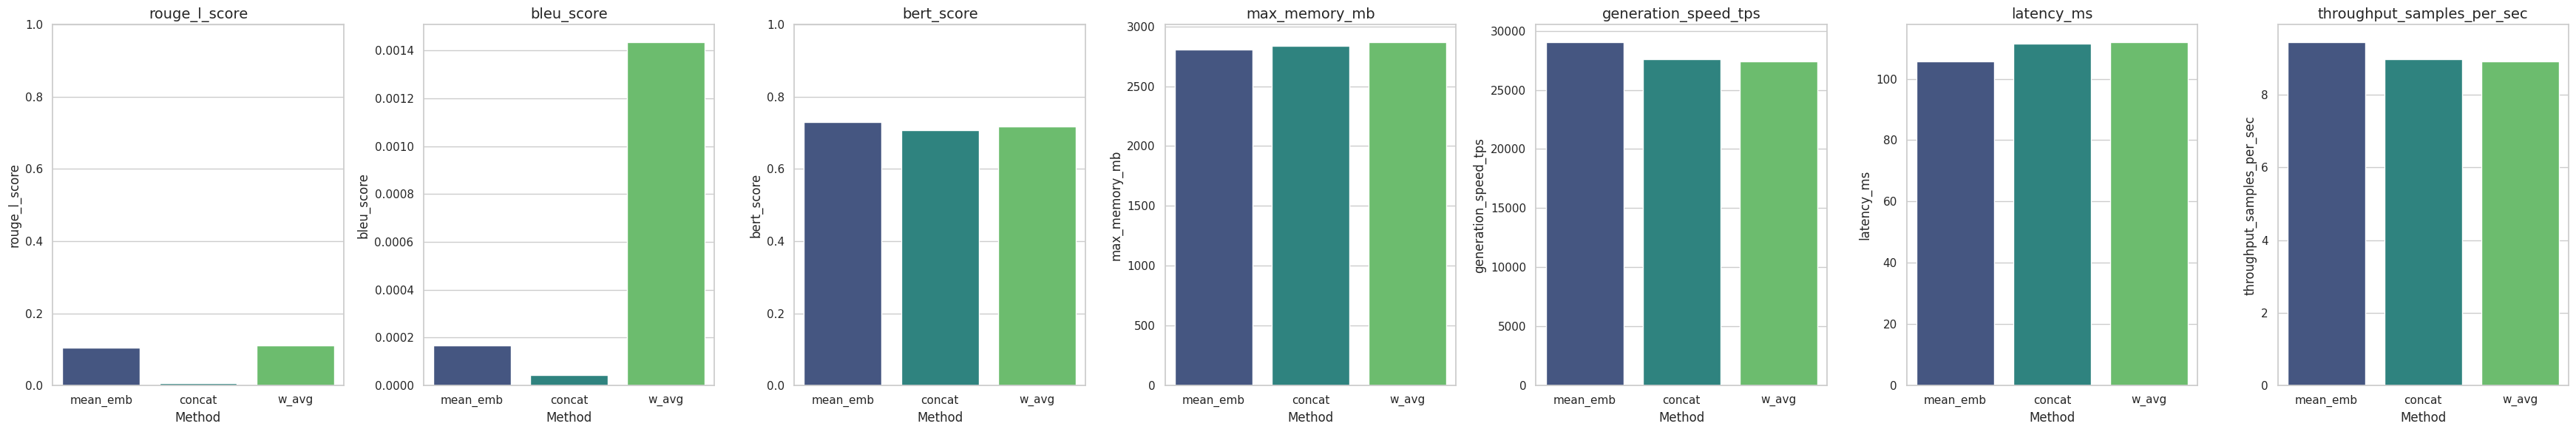

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df = pd.DataFrame(results).T 

# Plotting
sns.set(style="whitegrid")
num_metrics = len(df.columns)
fig, axes = plt.subplots(nrows=1, ncols=num_metrics, figsize=(5 * num_metrics, 6))
axes = axes.flatten() if num_metrics > 1 else [axes]
for i, metric in enumerate(df.columns):
    sns.barplot(x=df.index, y=df[metric], ax=axes[i], palette="viridis")
    axes[i].set_title(f"{metric}", fontsize=14)
    axes[i].set_ylabel(metric)
    axes[i].set_xlabel("Method")

    if metric in ["bert_score", "rouge_l_score"]:
        axes[i].set_ylim(0, 1)

plt.tight_layout()
plt.show()